## Ingesting & Environment Setup

In [62]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [63]:
# Read csv file
df = pd.read_csv('../data/fusion_cleaned_dataset.csv', sep=',')
df.sample(3)

,username,id,caption,Fashion and Style,Food and Dining,Family and Relationships,Sports and Fitness,Entertainment,Business and Industry,Travel and Adventure,Arts and Culture,News,Pets,Technology and Gadgets
9503,readwithkat,17994065758701364,another week another new release tuesday this ...,0,0,0,0,1,0,0,1,0,0,0
9365,jamesmichaelforrest,17868238187789651,jmf vs who will winscroll to see the pics of t...,0,0,0,0,1,0,1,0,0,0,0
6481,usatf,18002629555625239,one more sleep from march 1012 the 2023 usatf ...,0,0,0,1,0,0,0,0,0,0,0


In [74]:
class Model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Model, self).__init__()
        self.model = torch.hub.load(
            'pytorch/vision:v0.9.0', 'vgg11', weights=pretrained)
        self.model.fc = torch.nn.Linear(
            self.model.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

# Load the models that we will use for the fusion using ANN
cnn_model = torch.load('../artifacts/cnn_instagram.pt', map_location=device)

# preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.functional.to_pil_image(x).convert('RGBA') if x.shape[0] == 4 else transforms.functional.to_pil_image(x)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [65]:
import re

all_interests= [
    'Fashion and Style',
    'Food and Dining',
    'Family and Relationships',
    'Sports and Fitness',
    'Entertainment',
    'Business and Industry',
    'Travel and Adventure',
    'Arts and Culture',
    'News',
    'Pets',
    'Technology and Gadgets'
]

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def prepare_data(input_text, tokenizer):
    input_text = clean_text(input_text)
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=all_interests):
    probs = model.predict(processed_data)[0]
    threshold = 0.1
    # Return a pandas series of interests with probability greater than threshold
    return pd.Series(data=probs, index=classes)[lambda x: x > threshold].sort_values(ascending=False)

# Define the custom layer
class CustomTFBertMainLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomTFBertMainLayer, self).__init__(*args, **kwargs)

    def call(self, inputs, **kwargs):
        # Implement the custom layer logic here
        pass

# Register the custom layer
tf.keras.utils.get_custom_objects()['CustomTFBertMainLayer'] = CustomTFBertMainLayer

# Load the BERT model
with tf.keras.utils.custom_object_scope({'CustomTFBertMainLayer': CustomTFBertMainLayer}):
    interest_model = tf.keras.models.load_model('../artifacts/bert_interest_model.h5')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [66]:
# Now we need to match, the posts with their images, using the username and the post id. ../data/images/username/post_id.jpg
# We will need to make a custom data loader, that uses the dataset we have to load the images and the text,
# Then we will need to plug the text into the BERT model, and the images into the CNN model, and then we will need to fuse the results
# into a single vector, and then we will need to use that vector to train a new model, that will be used for the final prediction

class CustomDataset(Dataset):
    def __init__(self, df, image_folder, tokenizer, transform):
        self.df = df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        username = self.df.iloc[idx]['username']
        post_id = self.df.iloc[idx]['id']
        caption = self.df.iloc[idx]['caption']
        image_path = os.path.join(self.image_folder, f'{username}/{post_id}.jpg')

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Prepare text data
        processed_data = prepare_data(caption, self.tokenizer)

        return image, processed_data

In [67]:
# Define your image folder path
image_folder = '../data/images'

# Create custom dataset
dataset = CustomDataset(df, image_folder, tokenizer, transform)

# Define a batch size for data loading
batch_size = 16

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

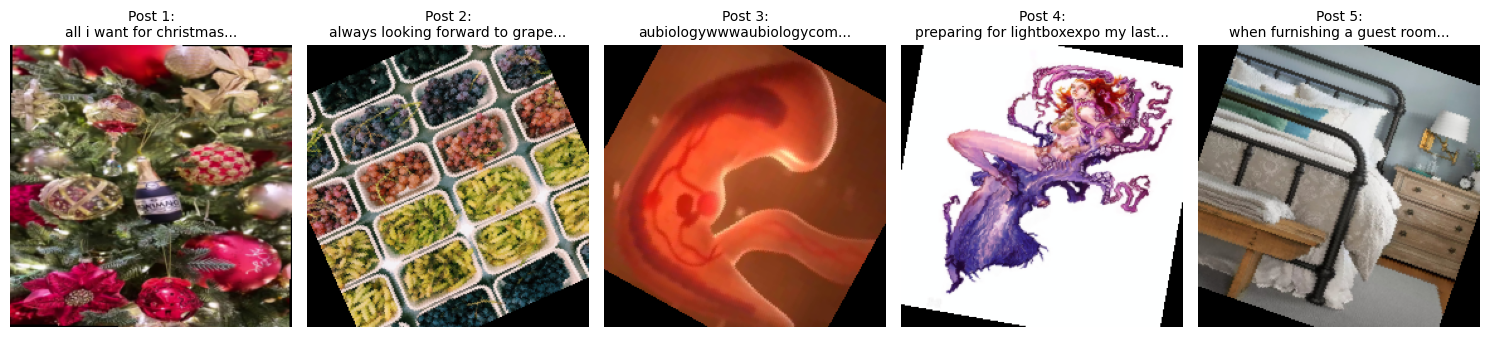

In [68]:
import random
import matplotlib.pyplot as plt

# Set the number of posts to display
num_posts = 5

# Get random indices
random_indices = random.sample(range(len(dataset)), num_posts)

# Plot the random posts
fig, axes = plt.subplots(nrows=1, ncols=num_posts, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, processed_data = dataset[idx]

    image = image.cpu().numpy().transpose((1, 2, 0))
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Undo normalization

    # Display the image
    axes[i].imshow(image)
    axes[i].axis('off')


    # Get the original text
    original_text = df.iloc[idx]['caption']

    # Display the text
    axes[i].set_title(f'Post {i+1}:\n{" ".join(original_text.split(" ")[:5])}...', fontsize=10)

plt.tight_layout()
plt.show()


In [75]:
# Fusion model
class FusionModel(nn.Module):
    def __init__(self, bert_model, cnn_model, num_classes):
        super(FusionModel, self).__init__()
        self.bert_model = bert_model
        cnn_model = Model(num_classes)
        cnn_model.load_state_dict(cnn_model)
        cnn_model = cnn_model.to(device)
        cnn_model.eval()  # Set the model to evaluation mode
        self.cnn_model = cnn_model
        

    def forward(self, image_inputs, text_inputs):
        # Get the BERT model outputs
        bert_outputs = self.bert_model.predict(text_inputs)
        # Get the CNN model outputs
        # Perform predictions
        with torch.no_grad():
            cnn_outputs = cnn_model(image_inputs)
            
        print(bert_outputs.shape)
        print(cnn_outputs.shape)

In [ ]:
# Create fusion model
fusion_model = FusionModel(interest_model, cnn_model, num_classes=len(all_interests))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)

In [33]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0

    for images, texts in data_loader:
        images = images.to(device)
        texts = {key: value.to(device) for key, value in texts.items()}

        optimizer.zero_grad()

        outputs = fusion_model(images, texts)
        labels = torch.tensor([all_interests.index(interest) for interest in df['interest'].tolist()]).to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


NameError: name 'fusion_model' is not defined

In [ ]:

# Save the trained fusion model
torch.save(fusion_model, 'fusion_model.pt')